# Calculating GB energy from DF

## Objective

(i) Select data from boundaries
(ii) Organize it for all grains
(iii) Calculate the energy with wield

## Method

    * Open Dataframe
    * Select attributes of interest from boundaries
    * Create a new DF with grain information
    * Convert data to wield
    * Run wield for all grains
    * Store energy in Dataframe

In [1]:
import pandas as pd
import numpy as np
from skimage import draw,io
from skimage.segmentation import flood, flood_fill

from matplotlib import pyplot as plt


### Open Dataframe


In [2]:

folder = "../data/"
file = "1_005"
path = folder + file

#%%

sample = np.loadtxt(path+ ".txt")

'''
# Column 1-3:   right hand average orientation (phi1, PHI, phi2 in radians)
# Column 4-6:   left hand average orientation (phi1, PHI, phi2 in radians)
# Column 7:     Misorientation Angle
# Column 8-10:  Misorientation Axis in Right Hand grain
# Column 11-13: Misorientation Axis in Left Hand grain
# Column 14:    length (in microns)
# Column 15:    trace angle (in degrees)
# Column 16-19: x,y coordinates of endpoints (in microns)
# Column 20-21: IDs of right hand and left hand grains

'''


df = pd.DataFrame(  data = sample, 
                    columns = ["right_phi1","right_PHI","right_phi2",                 #1-3
                               "left_phi1","left_PHI","left_phi2",                    #4-6 
                               "ori_angle",                                           #7
                               "right_ori_x","right_ori_y","right_ori_z",              #8-10
                               "left_ori_x","left_ori_y","left_ori_z",                 #11-13  
                               "length",                                              #14
                               "trace_angle",                                         #15
                               "x_start", "y_start", "x_end", "y_end",                #16-19
                               "grain_right","grain_left"                             #20-21
                               ]                    
                 )


In [3]:
df.grain_right.drop_duplicates(keep = False)

10      1120.0
25      2455.0
35      3207.0
39      3372.0
44      3595.0
         ...  
7311    1901.0
7324    2874.0
7328    2486.0
7330    3008.0
7340     130.0
Name: grain_right, Length: 420, dtype: float64

### Select attributes of interest from boundaries

The group of information that is directly related to the grain: 
* Column 1-3:   right hand average orientation (phi1, PHI, phi2 in radians)
* Column 4-6:   left hand average orientation (phi1, PHI, phi2 in radians)
* Column 7:     Misorientation Angle
* Column 8-10:  Misorientation Axis in Right Hand grain
* Column 11-13: Misorientation Axis in Left Hand grain
* Column 20-21: IDs of right hand and left hand grains

The Columns 20-21 describe the grain of interest

The Columns 1-6 depends on grain itself, **here we are interested**

The Columns 7-13 depends on left and right grains

In [4]:
#df_left = df[['ori_angle','left_phi1','left_PHI','left_phi2','left_ori_x','left_ori_y','left_ori_z','grain_left']]
#df_right = df[['right_phi1','right_PHI','right_phi2','right_ori_x','right_ori_y','right_ori_z','grain_right']]

# left_ori is related with other grain, than is not interesting to keep in this case

df_left = df[['left_phi1','left_PHI','left_phi2','grain_left']]
df_left = df_left.rename(columns={"grain_left": "grain"})


df_right = df[['right_phi1','right_PHI','right_phi2','grain_right']]
df_right = df_right.rename(columns={"grain_right": "grain"})


In [5]:
df_left = df_left[~df_left.grain.duplicated()].sort_values('grain')
df_left = df_left.set_index('grain')


In [6]:
df_right = df_right[~df_right.grain.duplicated()].sort_values('grain')
df_right = df_right.set_index('grain')


In [7]:
#df_grains = pd.concat([df_left,df_right])
df_grains = df_left.join(df_right)
df_grains_l = df_left.join(df_right)
df_grains_r = df_right.join(df_left)

In [8]:
df_grains_l.isnull().sum(),df_grains_r.isnull().sum()

(left_phi1      0
 left_PHI       0
 left_phi2      0
 right_phi1    67
 right_PHI     67
 right_phi2    67
 dtype: int64,
 right_phi1     0
 right_PHI      0
 right_phi2     0
 left_phi1     34
 left_PHI      34
 left_phi2     34
 dtype: int64)

In [9]:
df_grains.sort_values('grain')

,left_phi1,left_PHI,left_phi2,right_phi1,right_PHI,right_phi2
grain,,,,,,
1.0,2.108,0.507,4.677,NaN,NaN,NaN
2.0,3.569,0.749,2.910,3.569,0.749,2.910
3.0,1.016,0.709,4.944,1.016,0.709,4.944
4.0,2.562,0.698,3.682,2.562,0.698,3.682
5.0,5.593,0.898,0.472,5.593,0.898,0.472
...,...,...,...,...,...,...
4217.0,3.249,0.193,3.117,3.249,0.193,3.117
4219.0,1.612,0.626,4.360,NaN,NaN,NaN
4220.0,1.188,0.543,4.660,1.188,0.543,4.660


In [10]:
df_grains.isnull().sum()

left_phi1      0
left_PHI       0
left_phi2      0
right_phi1    67
right_PHI     67
right_phi2    67
dtype: int64

## Fill Grains based on phi1, PHI, and phi2

In [11]:
df_grains_norm = (df_grains - df_grains.min()) / (df_grains.max() - df_grains.min())

In [12]:
grain = 100

One_grain = df[(df["grain_right"] == grain) | (df["grain_left"] == grain)]
One_grain

,right_phi1,right_PHI,right_phi2,left_phi1,left_PHI,left_phi2,ori_angle,right_ori_x,right_ori_y,right_ori_z,...,left_ori_y,left_ori_z,length,trace_angle,x_start,y_start,x_end,y_end,grain_right,grain_left
408,1.917,0.639,5.135,6.271,0.745,0.120,51.29,-21.0,-18.0,-5.0,...,-18.0,-5.0,17.243,129.6,29.0,47.92,40.0,61.20,119.0,100.0
409,6.271,0.745,0.120,0.858,0.219,5.426,36.96,18.0,-6.0,5.0,...,-6.0,5.0,13.614,42.7,29.0,47.92,39.0,38.68,100.0,79.0
458,3.569,0.749,2.910,6.271,0.745,0.120,12.89,14.0,-22.0,9.0,...,-22.0,9.0,16.042,4.1,39.0,38.68,55.0,37.53,2.0,100.0
462,6.271,0.745,0.120,3.202,0.343,3.108,28.15,-17.0,0.0,3.0,...,0.0,3.0,27.301,171.5,40.0,61.20,67.0,65.24,100.0,133.0
463,6.271,0.745,0.120,3.202,0.343,3.108,28.15,-17.0,0.0,3.0,...,0.0,3.0,9.165,70.9,67.0,65.24,70.0,56.58,100.0,133.0
532,6.271,0.745,0.120,2.559,0.670,3.099,40.34,-3.0,12.0,13.0,...,12.0,13.0,11.136,128.9,55.0,37.53,62.0,46.19,100.0,80.0
566,6.271,0.745,0.120,0.695,0.562,6.276,36.48,7.0,-20.0,-20.0,...,-20.0,-20.0,13.115,127.6,62.0,46.19,70.0,56.58,100.0,103.0


In [13]:
#del mask
grain_info = df_grains_norm.loc[grain,:]
grain_info

left_phi1     0.998248
left_PHI      0.719960
left_phi2     0.018946
right_phi1    0.998248
right_PHI     0.719960
right_phi2    0.018946
Name: 100.0, dtype: float64

In [14]:

width = 200#int(max([max(One_grain.x_end),max(One_grain.x_start)]))+1
height = 100#int(max([max(One_grain.y_end),max(One_grain.y_start)]))+1

width,height

(200, 100)

In [15]:
x_center = int(One_grain[['x_start','x_end']].mean().mean())
y_center = int(One_grain[['y_start','y_end']].mean().mean())

In [16]:
One_grain.y_start.iloc[1:3]

409    47.92
458    38.68
Name: y_start, dtype: float64

The method polygon_fill do not work because it uses the Even–odd rule and fill all closed paths based on directions provided as parameters. As the order or parameters meters and in our case is not ordered, this method is not helpful.


## Flood Fill method

In [17]:
One_grain.x_start

408    29.0
409    29.0
458    39.0
462    40.0
463    67.0
532    55.0
566    62.0
Name: x_start, dtype: float64

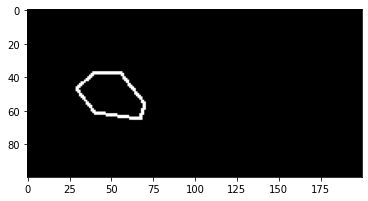

In [18]:

np_img = np.zeros([height, width, 3])
np_img2 = np.zeros([height, width, 3])

for idx, row in One_grain.iterrows():
    #print("%d %d %d %d\n" %(row.x_start.astype("uint16"),row.y_start.astype("uint16"),row.x_end.astype("uint16"),row.y_end.astype("uint16")))
    
    rr,cc,a = draw.line_aa(row.x_start.astype("uint16"),row.y_start.astype("uint16"),row.x_end.astype("uint16"),row.y_end.astype("uint16"))
    np_img[cc,rr,:3] = (1,1,1)
    
#mask = flood_fill(np_img, (50, 52,1), 255 )
mask = flood(np_img, (y_center, x_center,0))
#np_img = flood_fill(np_img, (50, 52,0), 155 )
np.shape(mask[:,:,1])

plt.imshow(np_img)

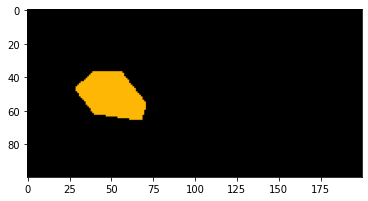

In [19]:
phi1,Phi,phi2 = grain_info[["right_phi1","right_PHI","right_phi2"]]
np_img2[mask[:,:,1]] = [phi1,Phi,phi2]
np_img2[np_img[:,:,1] !=0] =  [phi1,Phi,phi2]


plt.imshow(np_img2)

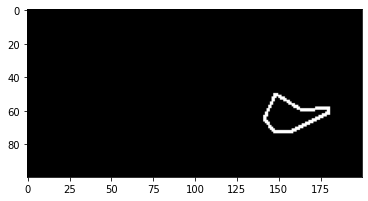

In [20]:
grain = 123

One_grain = df[(df["grain_right"] == grain) | (df["grain_left"] == grain)]
grain_info = df_grains_norm.loc[grain,:]
x_center = int(One_grain[['x_start','x_end']].mean().mean())
y_center = int(One_grain[['y_start','y_end']].mean().mean())

np_img = np.zeros([height, width, 3])
#np_img2 = np.zeros([height, width, 3])

for idx, row in One_grain.iterrows():
    #print("%d %d %d %d\n" %(row.x_start.astype("uint16"),row.y_start.astype("uint16"),row.x_end.astype("uint16"),row.y_end.astype("uint16")))
    
    rr,cc,a = draw.line_aa(row.x_start.astype("uint16"),row.y_start.astype("uint16"),row.x_end.astype("uint16"),row.y_end.astype("uint16"))
    np_img[cc,rr,:3] = (1,1,1)
    
    
#mask = flood_fill(np_img, (50, 52,1), 255 )
mask = flood(np_img, (y_center, x_center,0))
#np_img = flood_fill(np_img, (50, 52,0), 155 )
np.shape(mask[:,:,1])

plt.imshow(np_img)

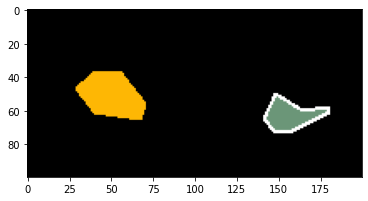

In [21]:
phi1,Phi,phi2 = grain_info[["right_phi1","right_PHI","right_phi2"]]
#np_img[np_img[:,:,1] !=0] =  [phi1,Phi,phi2]
np_img[mask[:,:,1] !=0] = [phi1,Phi,phi2]
np_img2 += np_img


plt.imshow(np_img2)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


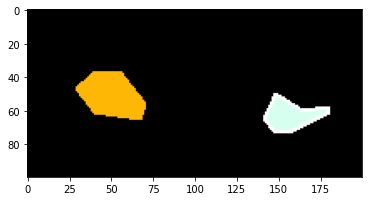

In [22]:
plt.imshow(np_img2+np_img)

Applying to all grains

In [30]:
from IPython.display import set_matplotlib_formats
plt.rcParams['figure.dpi'] = 200
plt.rcParams['savefig.dpi'] = 200
import cv2
import time
import math



df_grains_norm = (df_grains - df_grains.min()) / (df_grains.max() - df_grains.min())

width = int(max([max(df.x_end),max(df.x_start)]))+1
height = int(max([max(df.y_end),max(df.y_start)]))+1
np_img = np.zeros([height, width, 3])
flood_grains = np.zeros([height, width, 3])

#for idx, row in df.iterrows():
#    rr,cc,a = draw.line_aa(row.x_start.astype("uint16"),row.y_start.astype("uint16"),row.x_end.astype("uint16"),row.y_end.astype("uint16"))
#    np_img[cc,rr,:3] = (1,1,1)
    
#plt.imshow(np_img)


In [31]:
np.average(np_img)


0.0

In [32]:
np.average([phi1,Phi,phi2])

0.555629713358249

In [ ]:
#%%time

for grain in df_grains.index:
    One_grain = df[(df["grain_right"] == grain) | (df["grain_left"] == grain)]
    grain_info = df_grains_norm.loc[grain,:]
    np_img = np.zeros([height, width, 3])

  #  width = int(max([max(One_grain.x_end),max(One_grain.x_start)]))+1
  #  height = int(max([max(One_grain.y_end),max(One_grain.y_start)]))+1

    x_center = math.floor(One_grain[['x_start','x_end']].mean().mean())
    y_center = math.floor(One_grain[['y_start','y_end']].mean().mean())


    if(x_center <2100 and y_center < 2100):    
        phi1,Phi,phi2 = grain_info[["right_phi1","right_PHI","right_phi2"]]
        #    cv2.putText(np_img, text=str(int(grain)), org=(x_center,y_center),fontFace=2, fontScale=0.4, color=(255,255,255), thickness=1)
    
        for idx, row in One_grain.iterrows():
            
            rr,cc,a = draw.line_aa(row.x_start.astype("uint16"),row.y_start.astype("uint16"),row.x_end.astype("uint16"),row.y_end.astype("uint16"))
            np_img[cc,rr] = (1,1,1)
        
        mask = flood(np_img, (y_center, x_center,0))
        print(grain)
        print("len")
        print(np.count_nonzero(np_img))
        
        np_img[np_img[:,:,1] !=0] =  [phi1,Phi,phi2]
        np_img[mask[:,:,1] !=0] = [phi1,Phi,phi2]
#        cv2.imshow('NP',np_img)
#        cv2.waitKey(0)
#        cv2.destroyAllWindows()
        flood_grains += np_img


        cv2.imshow('Image',flood_grains)
        cv2.waitKey(0)
#        cv2.destroyAllWindows()

plt.imshow(flood_grains)
#io.imsave("processing/"+ file +'.png',np_img)

1.0
len
18
2.0
len
681
3.0
len
222
4.0
len
534
5.0
len
84
6.0
len
1263
7.0
len
1242
10.0
len
528
11.0
len
72
12.0
len
201
14.0
len
726
15.0
len
447
16.0
len
123
17.0
len
651
18.0
len
303
19.0
len
348
21.0
len
537
22.0
len
198
23.0
len
1314
24.0
len
348
25.0
len
939
26.0
len
54
27.0
len
357
28.0
len
447
29.0
len
1218
30.0
len
927
31.0
len
855
32.0
len
150
33.0
len
882
34.0
len
132
35.0
len
273
36.0
len
240
37.0
len
96
38.0
len
810
39.0
len
576
40.0
len
564


In [ ]:
cv2.imshow('f',flood_grains)
cv2.waitKey(0)
cv2.destroyAllWindows()

In [ ]:
io.imsave("processing/"+ file +'_partial.png',np_img)

Some grains are not in the df_grains dataframe.

In [ ]:
df[df["grain_left"].isnull()]

In [ ]:
df["grain_left"].unique()

In [ ]:
for a in df["grain_right"].unique():
    for b in df["grain_left"].unique():
        if a == b:
          # print("right found " + str(a))
            break
        if b == df["grain_left"].unique()[-1]:
            print("right not found " + str(a))

In [ ]:
for a in df["grain_left"].unique():
    for b in df["grain_right"].unique():
        if a == b:
          # print("right found " + str(a))
            break
        if b == df["grain_right"].unique()[-1]:
            print("left not found " + str(a))

In [ ]:
df

In [ ]:
len(df_grains.index)